# 0. Import Data 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# Import data from Amazon S3 Bucket
role = get_execution_role()
bucket='project-b-data'
data_key = 'proj-b/Tape_with_LOB/Tape_with_LOB1.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

data = pd.read_csv(data_location)
data.head()

/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Price,Quantity,Party1,Party2,Bid,Ask
0,2022-01-04,8.192,203,2.0,S26,B24,"[[203, 2], [199, 3], [195, 4], [187, 5], [181,...","[[207, 4], [211, 4], [214, 2], [220, 5], [226,..."
1,2022-01-04,8.192,199,3.0,S26,B08,"[[203, 2], [199, 3], [195, 4], [187, 5], [181,...","[[207, 4], [211, 4], [214, 2], [220, 5], [226,..."
2,2022-01-04,10.336,196,3.0,S06,B07,"[[196, 3], [195, 4], [187, 8], [182, 1], [156,...","[[197, 4], [198, 3], [201, 1], [202, 4], [209,..."
3,2022-01-04,10.672,196,4.0,S01,B01,"[[195, 4], [187, 5], [183, 3], [182, 1], [156,...","[[196, 4], [201, 1], [203, 4], [209, 9], [214,..."
4,2022-01-04,11.040,201,1.0,S12,B31,"[[192, 4], [187, 5], [182, 1], [176, 5], [168,...","[[201, 1], [203, 4], [205, 5], [209, 4], [214,..."


---
# 1. Data Preparation 

<b>1.1 Adding features to the LOB data for reinforcement learning model. New features include:
1. Highest bid price
2. Quantity of stocks with highest bid price
3. Lowest ask price
4. Quantity of stocks with lowest ask price
5. Bid-ask spread
6. Mid-price
7. Market depth

In [3]:
import ast 
import numpy as np

In [4]:
def get_highest_bid_price(bid):
    if type(bid) != float:
        new_bid = ast.literal_eval(bid)
        new_bid = np.array(new_bid)
        return new_bid[:,0][0]
    else:
        return 0

In [5]:
data['highest_bid_price'] = data.apply(lambda bid: get_highest_bid_price(bid['Bid']), axis=1)

In [6]:
def get_highest_bid_quantity(bid):
    if type(bid) != float:
        new_bid = ast.literal_eval(bid)
        new_bid = np.array(new_bid)
        return max(new_bid[:,1])
    else:
        return 0

In [7]:
data['highest_bid_quantity'] = data.apply(lambda bid: get_highest_bid_quantity(bid['Bid']), axis=1)

In [8]:
def get_lowest_ask_price(ask):
    if type(ask) != float:
        new_ask = ast.literal_eval(ask)
        new_ask = np.array(new_ask)
        return new_ask[:,0][0]
    else:
        return 0

In [9]:
data['lowest_ask_price'] = data.apply(lambda ask: get_lowest_ask_price(ask['Ask']), axis=1)

In [10]:
def get_lowest_ask_quantity(ask):
    if type(ask) != float:
        new_ask = ast.literal_eval(ask)
        new_ask = np.array(new_ask)
        return min(new_ask[:,1])
    else:
        return 0

In [11]:
data['lowest_ask_quantity'] = data.apply(lambda ask: get_lowest_ask_quantity(ask['Ask']), axis=1)
data['Spread'] = data['lowest_ask_price']-data['highest_bid_price']
data['Mid_price'] =(data['lowest_ask_price']+data['highest_bid_price'])/2

In [12]:
def get_Market_depth(ask,bid):
    if type(ask) != float and type(bid) !=float:
        new_ask = ast.literal_eval(ask)
        new_ask = np.array(new_ask)
        new_bid = ast.literal_eval(bid)
        new_bid = np.array(new_bid)
        return new_ask[:,0][-1]-new_bid[:,0][-1]
    else:
        return 0

In [13]:
data['Market_depth']=list(map(lambda ask,bid:get_Market_depth(ask,bid), data['Ask'], data['Bid']))

In [14]:
data.head()

,Date,Time,Price,Quantity,Party1,Party2,Bid,Ask,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth
0,2022-01-04,8.192,203,2.0,S26,B24,"[[203, 2], [199, 3], [195, 4], [187, 5], [181,...","[[207, 4], [211, 4], [214, 2], [220, 5], [226,...",203,5,207,2,4,205.0,747
1,2022-01-04,8.192,199,3.0,S26,B08,"[[203, 2], [199, 3], [195, 4], [187, 5], [181,...","[[207, 4], [211, 4], [214, 2], [220, 5], [226,...",203,5,207,2,4,205.0,747
2,2022-01-04,10.336,196,3.0,S06,B07,"[[196, 3], [195, 4], [187, 8], [182, 1], [156,...","[[197, 4], [198, 3], [201, 1], [202, 4], [209,...",196,8,197,1,1,196.5,764
3,2022-01-04,10.672,196,4.0,S01,B01,"[[195, 4], [187, 5], [183, 3], [182, 1], [156,...","[[196, 4], [201, 1], [203, 4], [209, 9], [214,...",195,5,196,1,1,195.5,764
4,2022-01-04,11.040,201,1.0,S12,B31,"[[192, 4], [187, 5], [182, 1], [176, 5], [168,...","[[201, 1], [203, 4], [205, 5], [209, 4], [214,...",192,5,201,1,9,196.5,592


<b>1.2 Adding features using transaction (tape) data for reinforcement learning model. New features include:
1. Highest price in a given time period 
2. Lowest price in a given time period
3. Opening prices of a trading session
4. Closing prices of a trading session
5. Volume of transactions in a given time period

In [15]:
#Drop columns that are not needed
df = data.drop(columns=['Party1','Party2','Bid','Ask'])
df.head()

,Date,Time,Price,Quantity,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth
0,2022-01-04,8.192,203,2.0,203,5,207,2,4,205.0,747
1,2022-01-04,8.192,199,3.0,203,5,207,2,4,205.0,747
2,2022-01-04,10.336,196,3.0,196,8,197,1,1,196.5,764
3,2022-01-04,10.672,196,4.0,195,5,196,1,1,195.5,764
4,2022-01-04,11.040,201,1.0,192,5,201,1,9,196.5,592


In [16]:
# new data frame with split value columns
new = df["Date"].str.split("-", n = 2, expand = True)
  
# making separate first name column from new data frame
df['Y'] = new[0]
# making separate last name column from new data frame
df['M'] = new[1]
df['D'] = new[2]

df[["Y", "M","D"]] = df[["Y", "M","D"]].apply(pd.to_numeric)

In [17]:
import datetime

#Create datetime column based on  given Time column
from datetime import datetime, timedelta
from datetime import datetime, datetime

dt = []
for i in range(len(df)):
    start = datetime(df['Y'][i], df['M'][i], df['D'][i], 8, 0, 0) #start time when market opens
    dt.append(start + timedelta(seconds = df["Time"][i]))

df['DateTime'] = dt
df.head()

,Date,Time,Price,Quantity,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth,Y,M,D,DateTime
0,2022-01-04,8.192,203,2.0,203,5,207,2,4,205.0,747,2022,1,4,2022-01-04 08:00:08.192
1,2022-01-04,8.192,199,3.0,203,5,207,2,4,205.0,747,2022,1,4,2022-01-04 08:00:08.192
2,2022-01-04,10.336,196,3.0,196,8,197,1,1,196.5,764,2022,1,4,2022-01-04 08:00:10.336
3,2022-01-04,10.672,196,4.0,195,5,196,1,1,195.5,764,2022,1,4,2022-01-04 08:00:10.672
4,2022-01-04,11.040,201,1.0,192,5,201,1,9,196.5,592,2022,1,4,2022-01-04 08:00:11.040


In [18]:
#High, low, open and close prices for every 5 minutes interval
prices = df.resample('1H', on='DateTime').Price.agg(['min','max', 'first','last'])
prices.reset_index(inplace=True)
prices

,DateTime,min,max,first,last
0,2022-01-04 08:00:00,179.0,218.0,203.0,207.0
1,2022-01-04 09:00:00,186.0,221.0,217.0,189.0
2,2022-01-04 10:00:00,189.0,228.0,189.0,227.0
3,2022-01-04 11:00:00,194.0,228.0,227.0,225.0
4,2022-01-04 12:00:00,195.0,231.0,225.0,224.0
...,...,...,...,...,...
2764,2022-04-29 12:00:00,105.0,136.0,126.0,135.0
2765,2022-04-29 13:00:00,105.0,136.0,135.0,131.0
2766,2022-04-29 14:00:00,104.0,135.0,131.0,135.0
2767,2022-04-29 15:00:00,104.0,135.0,135.0,122.0


In [19]:
df_Q = df.drop(columns=['Date', 'Time', 'Price', 'Y', 'M', 'D','highest_bid_price','highest_bid_quantity','lowest_ask_price','lowest_ask_quantity','Spread','Mid_price','Market_depth'])
df_Q.head()

,Quantity,DateTime
0,2.0,2022-01-04 08:00:08.192
1,3.0,2022-01-04 08:00:08.192
2,3.0,2022-01-04 08:00:10.336
3,4.0,2022-01-04 08:00:10.672
4,1.0,2022-01-04 08:00:11.040


In [20]:
df_Q[["Quantity"]] = df[["Quantity"]].apply(pd.to_numeric)

qty = df_Q.resample('1H', on='DateTime').sum()
qty

,Quantity
DateTime,
2022-01-04 08:00:00,13908.0
2022-01-04 09:00:00,14092.0
2022-01-04 10:00:00,13830.0
2022-01-04 11:00:00,13692.0
2022-01-04 12:00:00,13911.0
...,...
2022-04-29 12:00:00,13975.0
2022-04-29 13:00:00,14139.0
2022-04-29 14:00:00,13812.0


In [21]:
Quantity = qty['Quantity'].tolist()

prices['Quantity'] = Quantity
prices.dropna(subset=['min'], inplace=True)
prices.head()

,DateTime,min,max,first,last,Quantity
0,2022-01-04 08:00:00,179.0,218.0,203.0,207.0,13908.0
1,2022-01-04 09:00:00,186.0,221.0,217.0,189.0,14092.0
2,2022-01-04 10:00:00,189.0,228.0,189.0,227.0,13830.0
3,2022-01-04 11:00:00,194.0,228.0,227.0,225.0,13692.0
4,2022-01-04 12:00:00,195.0,231.0,225.0,224.0,13911.0


In [22]:
prices.rename(columns = {'DateTime':'Date', 'min':'Low', 'max':'High', 'first':'Open', 'last':'Close', 'Quantity':'Volume'}, inplace = True)
prices.set_index('Date', inplace=True)
prices

,Low,High,Open,Close,Volume
Date,,,,,
2022-01-04 08:00:00,179.0,218.0,203.0,207.0,13908.0
2022-01-04 09:00:00,186.0,221.0,217.0,189.0,14092.0
2022-01-04 10:00:00,189.0,228.0,189.0,227.0,13830.0
2022-01-04 11:00:00,194.0,228.0,227.0,225.0,13692.0
2022-01-04 12:00:00,195.0,231.0,225.0,224.0,13911.0
...,...,...,...,...,...
2022-04-29 12:00:00,105.0,136.0,126.0,135.0,13975.0
2022-04-29 13:00:00,105.0,136.0,135.0,131.0,14139.0
2022-04-29 14:00:00,104.0,135.0,131.0,135.0,13812.0


In [23]:
df_Lob = df.drop(columns=['Quantity','Date', 'Time', 'Price', 'Y', 'M', 'D'])
df_Lob.head()

,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth,DateTime
0,203,5,207,2,4,205.0,747,2022-01-04 08:00:08.192
1,203,5,207,2,4,205.0,747,2022-01-04 08:00:08.192
2,196,8,197,1,1,196.5,764,2022-01-04 08:00:10.336
3,195,5,196,1,1,195.5,764,2022-01-04 08:00:10.672
4,192,5,201,1,9,196.5,592,2022-01-04 08:00:11.040


In [24]:
lob = df_Lob.resample('1H', on='DateTime').last()
lob.head()

,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth,DateTime
DateTime,,,,,,,,
2022-01-04 08:00:00,207.0,5.0,237.0,1.0,30.0,222.0,670.0,2022-01-04 08:59:58.272
2022-01-04 09:00:00,173.0,4.0,189.0,1.0,16.0,181.0,598.0,2022-01-04 09:59:59.984
2022-01-04 10:00:00,227.0,11.0,241.0,1.0,14.0,234.0,731.0,2022-01-04 10:59:59.904
2022-01-04 11:00:00,225.0,14.0,400.0,1.0,175.0,312.5,685.0,2022-01-04 11:59:58.848
2022-01-04 12:00:00,224.0,5.0,315.0,1.0,91.0,269.5,615.0,2022-01-04 12:59:58.720


In [25]:
lob.dropna(subset=['highest_bid_price'], inplace=True)

In [26]:
dataframe = pd.concat([prices,lob],axis=1)
dataframe = dataframe.drop(columns=['DateTime'])

In [27]:
dataframe.index.name = 'DateTime'
dataframe.head()

,Low,High,Open,Close,Volume,highest_bid_price,highest_bid_quantity,lowest_ask_price,lowest_ask_quantity,Spread,Mid_price,Market_depth
DateTime,,,,,,,,,,,,
2022-01-04 08:00:00,179.0,218.0,203.0,207.0,13908.0,207.0,5.0,237.0,1.0,30.0,222.0,670.0
2022-01-04 09:00:00,186.0,221.0,217.0,189.0,14092.0,173.0,4.0,189.0,1.0,16.0,181.0,598.0
2022-01-04 10:00:00,189.0,228.0,189.0,227.0,13830.0,227.0,11.0,241.0,1.0,14.0,234.0,731.0
2022-01-04 11:00:00,194.0,228.0,227.0,225.0,13692.0,225.0,14.0,400.0,1.0,175.0,312.5,685.0
2022-01-04 12:00:00,195.0,231.0,225.0,224.0,13911.0,224.0,5.0,315.0,1.0,91.0,269.5,615.0


---
# 2. Exploratory Data Analysis 

Text(0.5, 1.0, 'Correlation Heatmap')

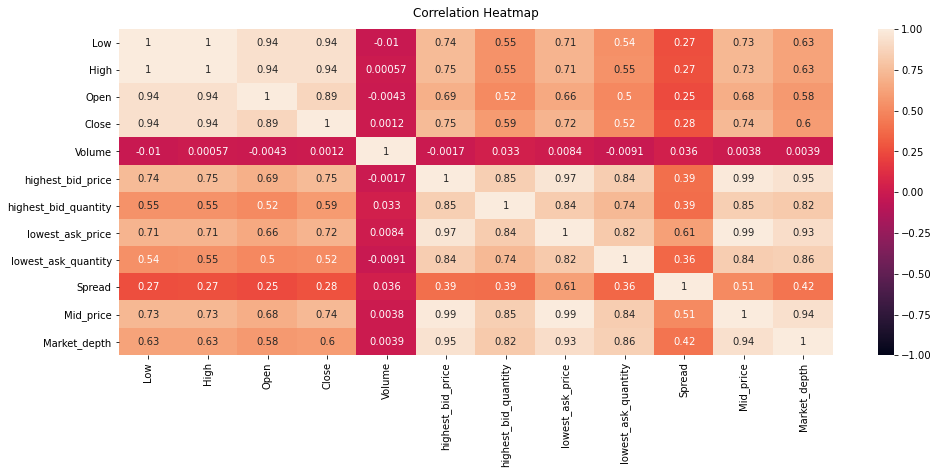

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dataframe.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

---
# 3. Install and Import dependencies for Reinforcement Learning Model

In [29]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_latest_p37/bin/python -m pip install --upgrade pip' command.


In [30]:
# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/ec2-user/anaconda3/envs/mxnet_latest_p37/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


---
# 4. Build environment

In [31]:
from gym_anytrading.envs import StocksEnv

In [32]:
env = gym.make('stocks-v0', df=prices, frame_bound=(10,600), window_size=10)

In [33]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    price = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['High','Open','Low','Close','Volume','highest_bid_price','highest_bid_quantity','lowest_ask_price','lowest_ask_quantity','Spread','Mid_price','Market_depth']].to_numpy()[start:end]
    return price, signal_features

In [34]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=dataframe, window_size=10, frame_bound=(10,600))

In [35]:
env2.prices

array([207., 189., 227., 225., 224., 198., 203., 231., 219., 231., 214.,
       235., 207., 203., 201., 206., 237., 212., 208., 230., 232., 231.,
       228., 218., 209., 220., 190., 218., 221., 220., 222., 215., 232.,
       201., 236., 206., 223., 226., 222., 192., 223., 220., 195., 213.,
       211., 212., 211., 179., 184., 209., 175., 194., 168., 195., 197.,
       191., 195., 190., 193., 193., 191., 186., 192., 193., 193., 195.,
       201., 202., 204., 206., 217., 188., 210., 191., 195., 199., 194.,
       224., 197., 195., 227., 217., 223., 202., 225., 192., 215., 216.,
       190., 205., 205., 188., 205., 203., 204., 195., 169., 164., 183.,
       189., 185., 188., 170., 166., 193., 196., 198., 197., 192., 203.,
       194., 188., 206., 215., 195., 216., 218., 222., 234., 234., 227.,
       196., 218., 202., 203., 237., 224., 233., 224., 228., 214., 202.,
       202., 203., 237., 232., 226., 204., 213., 207., 171., 197., 191.,
       158., 192., 183., 190., 178., 159., 185., 18

---
# 5. Build environment & train 

In [36]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [51]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

Wrapping the env in a DummyVecEnv.
---------------------------------
| explained_variance | 0.000446 |
| fps                | 19       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 2.21     |
---------------------------------
---------------------------------
| explained_variance | 0.736    |
| fps                | 444      |
| nupdates           | 100      |
| policy_entropy     | 0.692    |
| total_timesteps    | 500      |
| value_loss         | 3.9      |
---------------------------------
---------------------------------
| explained_variance | -0.0115  |
| fps                | 496      |
| nupdates           | 200      |
| policy_entropy     | 0.693    |
| total_timesteps    | 1000     |
| value_loss         | 0.819    |
---------------------------------
---------------------------------
| explained_variance | -0.00112 |
| fps                | 521      |
| nupdates           | 300      |
| policy_entr

KeyboardInterrupt: 

---
# 6. Evaluation 

In [95]:
env = MyCustomEnv(df=dataframe, window_size=10, frame_bound=(600,729))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 113.0, 'total_profit': 1.4070653861712237, 'position': 0}


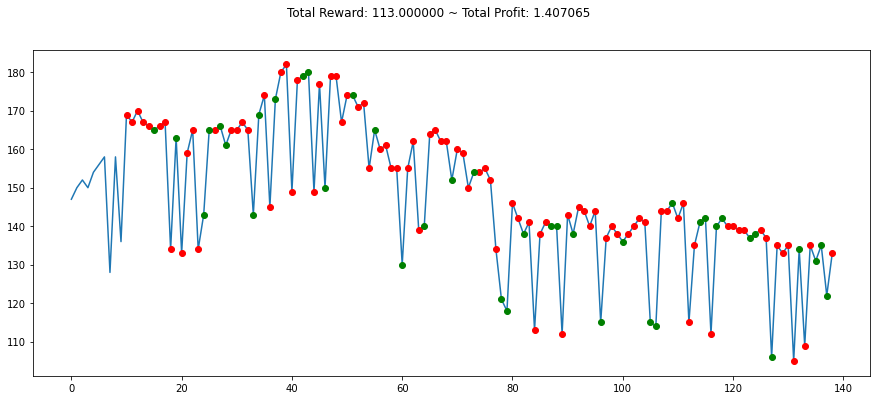

In [96]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

40.7% return over 129 days.

---
# 7. Additional Dataset (B02) 

In [98]:
# Import data from Amazon S3 Bucket
role = get_execution_role()
bucket2='project-b-new'
data_key2 = 'Tape_with_LOB/Tape_with_LOB_B02.csv'
data_location2 = 's3://{}/{}'.format(bucket2, data_key2)

data2 = pd.read_csv(data_location2)
data2.head()

,Date,Time,Price,Quantity,Party1,Party2,Bid,Ask
0,2022-01-04,10.778,253,1.0,S01,B08,"[[245, 5], [243, 1], [239, 1], [238, 1], [237,...","[[253, 1], [254, 5], [256, 6], [257, 1], [258,..."
1,2022-01-04,12.631,254,1.0,S03,B22,"[[253, 5], [252, 1], [250, 1], [238, 5], [231,...","[[254, 5], [256, 6], [257, 1], [258, 3], [259,..."
2,2022-01-04,12.835,254,4.0,S03,B12,"[[253, 5], [252, 1], [238, 5], [231, 2], [221,...","[[254, 4], [256, 6], [257, 1], [258, 3], [259,..."
3,2022-01-04,14.144,256,1.0,S10,B12,"[[255, 3], [254, 1], [252, 1], [238, 5], [235,...","[[256, 6], [257, 1], [258, 5], [259, 6], [260,..."
4,2022-01-04,14.484,256,1.0,S10,B28,"[[255, 3], [252, 3], [241, 1], [238, 4], [235,...","[[256, 5], [257, 1], [258, 3], [259, 6], [260,..."
